### What is this ?

Code for paper *Fundamental tradeoffs between memorization and robustness in random features and neural tangent regimes* https://arxiv.org/abs/2106.02630 (2021), by Elvis Dohmatob


In [ ]:
import warnings
from imp import reload

warnings.filterwarnings('ignore')

# disable abnoxious tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from scipy import linalg
from joblib import Parallel, delayed
from copy import deepcopy

import utils, models, new_models, keras_models


def get_fixtures(regime="rf", infinite_width=False, input_dim=None,
                 hidden_dim=None):
    if infinite_width:
        hidden_dim = np.inf
        if input_dim is None:
            input_dim = 500
        n_samples_list = np.arange(100, 1100, 100)
        n_samples_list = np.arange(100, 1500, 50)
        hidden_dims =  [hidden_dim]
    else:
        if regime == "ntk":
            if input_dim is None:
                input_dim = 50
            if hidden_dim is None:
                hidden_dim = 40
            min_n = min(input_dim, hidden_dim) // 2
            freq = 100
            p = hidden_dim * input_dim
            up = min(2 * p, 3000)
            n_samples_list = np.arange(min_n, up, freq)
            n_samples_list = np.concatenate((np.arange(5, min_n + 5, 5),
                                             n_samples_list,
                                             [input_dim, hidden_dim]))
            n_samples_list = np.unique(n_samples_list).astype(int)
            hidden_dims = [hidden_dim]
        elif regime  == "rf":
            if input_dim is None:
                input_dim = 300
            small = np.arange(10, 100, 20)
            big = np.arange(100, 1100, 100)
            n_samples_list = np.concatenate((small, big))
            hidden_dims = n_samples_list.copy()
        elif regime == "trainable":
            input_dim = 200
            n_samples_list = np.arange(100, 1100, 100)
            hidden_dims = [10, 50, 100, 150, 200]
        else:
            raise NotImplementedError(regime)
    
    return n_samples_list, input_dim, hidden_dims

### Run the experiments 

In [15]:
reload(utils)
reload(models)
reload(new_models)
reload(keras_models)

# setting demo = True runs in just a couple of minutes (recommended)
# setting this to demo = False reproduces the figures in our paper
demo = True
if demo:
    # should run in a couple of minutes
    regimes = ["rf"]
    infinite_widths = [False]
    ridge_params = [0, 1e-4, 1e-2]
    noise_sigmas = [0, .2, 1]
    n_models = 1
    n_datasets = 1
else:
    regimes = ["rf", "ntk"]
    infinite_widths = [False, True]
    ridge_params = [0, 1e-5, 1e-4, 1e-3]
    noise_sigmas = [0, .2, .4, .6, .8, 1]
    n_models = 5
    n_datasets = 5
    
activation_functions = ["relu", "abs", "erf", "tanh"]
n_samples_test = 500
n_jobs = 8  # tune according to available resources and time constraints

results = []

for regime in regimes:
    for infinite_width in infinite_widths:
        if regime == "rf":
            first_layer_variance = 0
            second_layer_variance = 1
        elif regime == "ntk":
            first_layer_variance = 1
            second_layer_variance = 0
        elif regime == "trainable":
            first_layer_variance = second_layer_variance = None
    
        for dataset_index in range(n_datasets):
            n_samples_list, input_dim, hidden_dims = get_fixtures(
                regime=regime, infinite_width=infinite_width)

            jobs = []

            if regime == "classical":
                for kind in ["gaussian", "laplace", "polynomial"]:
                    job = dict(dataset_index=dataset_index)
                    job["kind"] = kind
                    if kind == "gaussian":
                        job["c"] = .1
                    elif kind == "polynomial":
                        job["p"] = 2
                    jobs.append(job)
            else:
                for activation_function in activation_functions:
                    job = dict(dataset_index=dataset_index)
                    job["activation_function"] = activation_function
                    jobs.append(job)

            jobs = [dict(n_samples=n_samples, hidden_dim=hidden_dim,
                         noise_sigma=noise_sigma, ridge=ridge, **job)
                        for job in jobs
                        for noise_sigma in noise_sigmas
                        for n_samples in n_samples_list
                        for hidden_dim in hidden_dims
                        for ridge in ridge_params]

            if n_jobs > 1 and len(jobs) > 1:
                print(
                    "**Running %d experiments. Check your terminal to see run log" % (
                    len(jobs)))
            for res in Parallel(n_jobs=n_jobs)(delayed(utils.run_exp)(
                                regime=regime, input_dim=input_dim,
                                n_samples_test=n_samples_test,
                                ntk_first_layer_variance=first_layer_variance,
                                ntk_second_layer_variance=second_layer_variance,
                                n_models=n_models, **job) for job in jobs):
                if res is None:
                    continue
                results += res

**Running 8100 experiments. Check your terminal to see run log


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(results)
df["sqrt_n"] = np.sqrt(df["n_samples"])
df["gamma1"] = df["n_samples"] / df["input_dim"]
df["gamma"] = df["n_samples"] / df["hidden_dim"]
df["inv_gamma"] = df["hidden_dim"] / df["n_samples"]
df["sqrt_gamma"] = np.sqrt(df["gamma"])
df["normalized_sob_norm"] = df["sob_norm"] / df["sqrt_n"]
df["sqrt_gamma_normalized_sob_norm"] = df["sob_norm"] / df["sqrt_gamma"]
df["infinite_width"] = np.isinf(df["hidden_dim"])
df

,sob_norm,n_samples,input_dim,hidden_dim,activation_function,kind,noise_sigma,regime,v_norm,dataset_index,...,test squared loss,test hinge loss,sqrt_n,gamma1,gamma,inv_gamma,sqrt_gamma,normalized_sob_norm,sqrt_gamma_normalized_sob_norm,infinite_width
0,2.050372,10,300,10,relu,None,0.0,rf,8.956446e+00,0,...,0.015821,0.510,3.162278,0.033333,1.000000,1.0,1.000000,0.648385,2.050372,False
1,0.367706,10,300,10,relu,None,0.0,rf,1.616486e+00,0,...,0.003622,0.496,3.162278,0.033333,1.000000,1.0,1.000000,0.116279,0.367706,False
2,0.033699,10,300,10,relu,None,0.0,rf,1.519415e-01,0,...,0.003420,0.492,3.162278,0.033333,1.000000,1.0,1.000000,0.010656,0.033699,False
3,0.822400,10,300,30,relu,None,0.0,rf,6.512611e+00,0,...,0.005442,0.520,3.162278,0.033333,0.333333,3.0,0.577350,0.260066,1.424439,False
4,0.479581,10,300,30,relu,None,0.0,rf,3.607556e+00,0,...,0.003733,0.484,3.162278,0.033333,0.333333,3.0,0.577350,0.151657,0.830659,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,0.887400,1000,300,900,tanh,None,1.0,rf,1.392012e+01,0,...,1.101301,0.486,31.622777,3.333333,1.111111,0.9,1.054093,0.028062,0.841861,False
8096,0.012298,1000,300,900,tanh,None,1.0,rf,1.798368e-01,0,...,1.015482,0.500,31.622777,3.333333,1.111111,0.9,1.054093,0.000389,0.011667,False
8097,2422.240281,1000,300,1000,tanh,None,1.0,rf,1.586551e+07,0,...,8224.523334,0.468,31.622777,3.333333,1.000000,1.0,1.000000,76.597963,2422.240281,False
8098,1.000363,1000,300,1000,tanh,None,1.0,rf,1.542268e+01,0,...,1.013107,0.472,31.622777,3.333333,1.000000,1.0,1.000000,0.031634,1.000363,False


In [20]:
new_df = []
for (noise_sigma, input_dim), subdf in df.groupby(["noise_sigma", "input_dim"]):
    eps_opt1 = noise_sigma ** 2 + 1 / input_dim
    eps_opt2 = subdf["test squared loss"].min()
    print(eps_opt1, eps_opt2)
    if True:
        eps_opt = eps_opt1
    else:
        eps_opt = eps_opt2
    subdf["delta"] = eps_opt - subdf["train squared loss"]
    new_df.append(subdf)
df = pd.concat(new_df)
        
df["delta"]

0.0033333333333333335 2.8430742429113977e-08
0.04333333333333334 0.03498309179259327
1.0033333333333334 0.8241133752137519


0       0.003333
1       0.002807
2      -0.001872
3       0.003333
4       0.002433
          ...   
8095    0.063147
8096   -0.027347
8097    1.003333
8098    0.105639
8099   -0.039902
Name: delta, Length: 8100, dtype: float64

### Plot multiple-descent curves for test error and robustness


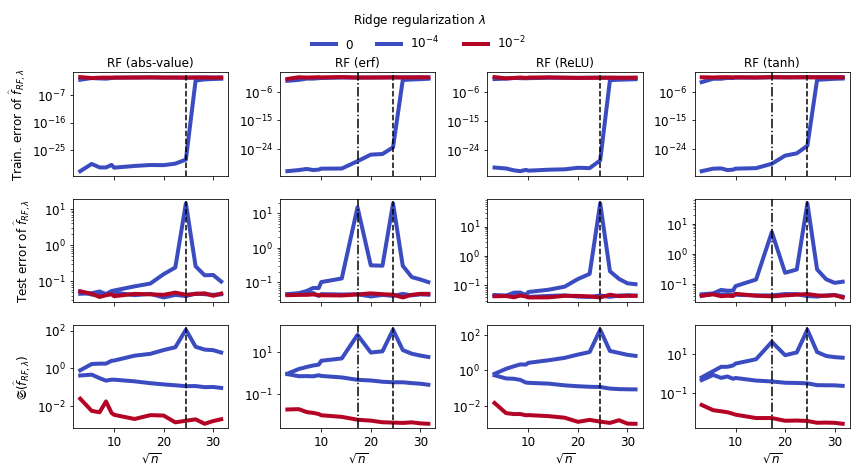

In [21]:
hue = "ridge"  # can be "ridge" or "noise_sigma"
activation_functions = ["abs", "erf", "relu", "tanh"]
activation_functions = [af for af in activation_functions
                        if af in df.activation_function.unique()]
yaxes = ["train squared loss", "test squared loss", "sob_norm"]
nrows = len(yaxes)
ncols = len(activation_functions)
infinite_width = False
linewidth = 4
fontsize = 12
cm = plt.cm.get_cmap("coolwarm", len(df[hue].unique()))
for regime in ["ntk", "rf"]:
    hidden_dim = None
    xaxis = "sqrt_n"
    if regime == "ntk":
        xaxis = "sqrt_gamma"
        hidden_dim = 40
        input_dim = 50
    elif regime == "rf":
        input_dim = 300
        hidden_dim = 600
    mask = df.regime == regime
    mask *= df.infinite_width == infinite_width
    mask *= df.input_dim == input_dim
    mask *= df.hidden_dim == hidden_dim

    if hue == "ridge":
        fancy_hue = "Ridge regularization $\\lambda$"
        mask *= df.noise_sigma == .2
    elif hue == "noise_sigma":
        fancy_hue = "Label noise level $\\zeta$"
        mask *= df.ridge == 0

    if mask.sum() == 0:
        continue
    _, axes_ = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 2),
                            sharex=True)
    axes_ = axes_.reshape((nrows, ncols))
    for yaxis, axes in zip(yaxes, axes_):
        for i, (ax, af) in enumerate(zip(axes, activation_functions)):
            subdf = df.loc[mask & (df.activation_function == af)]
            sns.lineplot(data=subdf, x=xaxis, y=yaxis, hue=hue,
                         palette=cm,
                         ax=ax, linewidth=linewidth)
            if ax.legend_ is not None:
                ax.legend_.remove()
            ax.set_yscale("log")
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            
            if yaxis == yaxes[0]:
                ax.set_title("%s (%s)" % (regime.upper(),af.replace(
                    "relu", "ReLU").replace("abs", "abs-value")),
                             fontsize=fontsize)
    
            if i == 0:
                ax.set_ylabel("...")
            else:
                ax.set_ylabel("")
                
            if xaxis == "sqrt_n":
                ax.set_xlabel("$\\sqrt{n}$", fontsize=fontsize)
            elif xaxis == "sqrt_gamma":
                ax.set_xlabel("$\\sqrt{n/k}$", fontsize=fontsize)
                
            if not infinite_width:
                if regime == "ntk":
                    ax.axvline(np.sqrt(input_dim), c="k")
                    if af in ["erf", "tanh"]:
                        ax.axvline(1, linestyle="--", c="k")
                elif regime == "rf":
                    ax.axvline(np.sqrt(hidden_dim), linestyle="--", c="k")
                    if af in ["erf", "tanh"]:
                        ax.axvline(np.sqrt(input_dim), linestyle="-.", c="k")
                
            if i == 0:
                if yaxis == "sob_norm":
                    ax.set_ylabel("$\\mathfrak{S}(\\widehat{f}_{%s,\\lambda})$" % (
                    regime.upper()), fontsize=fontsize)
                elif yaxis == "test squared loss":
                    ax.set_ylabel("Test error of $\\widehat{f}_{%s,\\lambda}$" % (
                    regime.upper()), fontsize=fontsize)
                elif yaxis == "train squared loss":
                    ax.set_ylabel(
                        "Train. error of $\\widehat{f}_{%s,\\lambda}$" % (
                    regime.upper()), fontsize=fontsize)
    plt.tight_layout()
    if hue == "ridge":
        loc = (-2.5, 3.6)
    else:
        loc = (-2.9, 3.6)
    if regime == regimes[0]:
        plt.legend([0 if ridge == 0 else "$10^{%d}$" % (
                        int(np.floor(np.log10(ridge))))
                                    for ridge in df.ridge.unique()] if hue == "ridge"
                   else df.noise_sigma.unique(),
                   title=fancy_hue, loc=loc, ncol=len(df[hue].unique()),
                   frameon=False, fontsize=fontsize, title_fontsize=fontsize)